### Neoantigen_Genes

This notebook looks at the genes that were predicted to be MHC binders.
- Venn diagrams across alleles
- Bar plot to show relative proportion of binders for each allele

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
from multiprocessing import Pool

gene_table_hs = pd.read_csv('../../goatools/gene_result_hs.txt', delimiter='\t')
symbol_id_dict = gene_table_hs.set_index('Symbol').to_dict()['GeneID']

%matplotlib inline

/dfs/project/cross-species/xspecies/lib/python3.7/site-packages/pandas/core/dtypes/common.py:1776: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  npdtype = np.dtype(dtype)


In [2]:
import matplotlib
from pylab import figure, cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

font = {'size'   : 16}
matplotlib.rc('font', **font)

def xid_to_entrez(k):
    k = ':'.join(k.split('_'))
    v = ID_dict[k]
    try:
        return symbol_id_dict[v.split('|')[2].split(':')[1]]
    except:
        return -1

In [3]:
from fractions import Fraction

In [4]:
# Read an parse binder information for each protein
def get_binders(f):
    
    with open(f, "r+") as read:
            text=read.readlines()

    binders = []
    for it, line in enumerate(text):
        if line[0:7]=='Protein':
            high = line.split('high binders ')[-1].split('.')[0]
            weak = line.split('weak binders ')[-1].split('.')[0]
            id_ = line.split('Protein ')[-1].split('.')[0]
            binders.append([id_, int(high), int(weak)])

    return binders

In [5]:
alleles = ['HLA-A03_01', 'HLA-B07_02', 'HLA-B35_03', 'HLA-C04_01', 'HLA-C07_02']

In [136]:
for allele in alleles:
    files = glob.glob('/dfs/user/yhr/neopeptide/results/'+allele+'/*')

    all_binders = []
    for it, f in enumerate(files):
        if f[-2:] != 'sh' or f[-2:] != 'ip':
            try:
                print(it)
                all_binders.extend(get_binders(f))
            except:
                continue    

    all_binders_df = pd.DataFrame(all_binders, columns=['ID', 'high', 'weak'])

    all_binders_df['weak'] = all_binders_df['weak'].astype(int)
    all_binders_df['high'] = all_binders_df['high'].astype(int)
    all_binders_df['any'] = all_binders_df['weak']+all_binders_df['high']

    all_binders_df.to_pickle('all_binders_'+allele+'.pkl')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


In [6]:
import pickle

ID_dict = np.load('/lfs/rambo/0/yhr/neopeptide/tim_data/ID_dict.npy', allow_pickle=True)
ID_dict = ID_dict.item()

In [7]:
binder_data = {}

for allele in alleles:
    all_binders_df = pd.read_pickle('../data/all_binders_'+allele+'.pkl')
    
    all_ID = list(set(all_binders_df['ID'].values))
    binders_ID = list(set(all_binders_df[all_binders_df['any']>0]['ID'].values))
    nonbinders_ID = list(set(all_binders_df[all_binders_df['any']==0]['ID'].values))
    highbinders_ID = list(set(all_binders_df[all_binders_df['high']>0]['ID'].values))
    nothigh_df = all_binders_df[all_binders_df['high']==0]
    weakbinders_ID = list(set(nothigh_df[nothigh_df['weak']>0]['ID'].values))
    
    
    all_geneID = list(set([xid_to_entrez(g) for g in all_ID]))
    binders_geneID = list(set([xid_to_entrez(g) for g in binders_ID]))
    nonbinders_geneID = list(set(all_geneID).difference(set(binders_geneID)))
    highbinders_geneID = list(set([xid_to_entrez(g) for g in highbinders_ID]))
    weakbinders_geneID = list(set(binders_geneID).difference(set(highbinders_geneID)))
    
    binder_data[allele] = {}
    
    binder_data[allele]['guide'] = {}
    binder_data[allele]['guide']['all'] = all_ID
    binder_data[allele]['guide']['binders'] = binders_ID
    binder_data[allele]['guide']['nonbinders'] = nonbinders_ID
    binder_data[allele]['guide']['highbinders'] = highbinders_ID
    binder_data[allele]['guide']['weakbinders'] = weakbinders_ID
    
    binder_data[allele]['gene'] = {}
    binder_data[allele]['gene']['all'] = all_geneID
    binder_data[allele]['gene']['binders'] = binders_geneID
    binder_data[allele]['gene']['nonbinders'] = nonbinders_geneID
    binder_data[allele]['gene']['highbinders'] = highbinders_geneID
    binder_data[allele]['gene']['weakbinders'] = weakbinders_geneID
    
#np.save('all_binder_data_dict', binder_data)

In [8]:
import sys 
sys.path.append('../../pyvenn/')

import venn

In [9]:
alleles

['HLA-A03_01', 'HLA-B07_02', 'HLA-B35_03', 'HLA-C04_01', 'HLA-C07_02']

### Venn diagrams

Text(0.5, 1.0, 'Genes predicted to have no MHC binding activity')

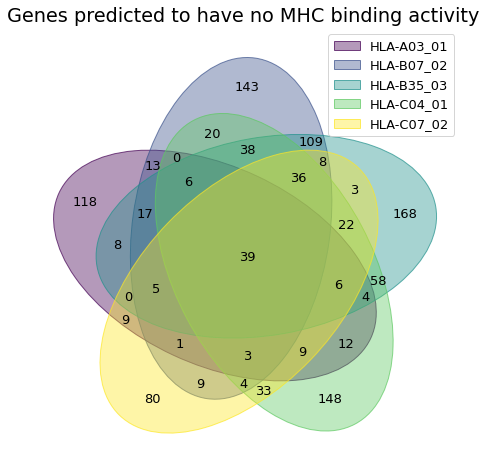

In [24]:
sets = {alleles[i]: set(binder_data[alleles[i]]['gene']['nonbinders']) for i in range(len(alleles))}
venn.venn(sets)
plt.savefig("fig2a_1.svg")
plt.title('Genes predicted to have no MHC binding activity')

Text(0.5, 1.0, 'Genes predicted to have no MHC binding activity')

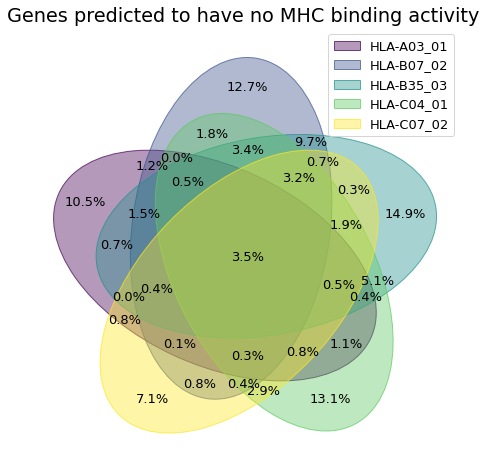

In [25]:
sets = {alleles[i]: set(binder_data[alleles[i]]['gene']['nonbinders']) for i in range(len(alleles))}
venn.venn(sets, fmt="{percentage:.1f}%")
plt.savefig("fig2a_2.svg")
plt.title('Genes predicted to have no MHC binding activity')

Text(0.5, 1.0, 'Genes predicted to not have strong MHC binding activity')

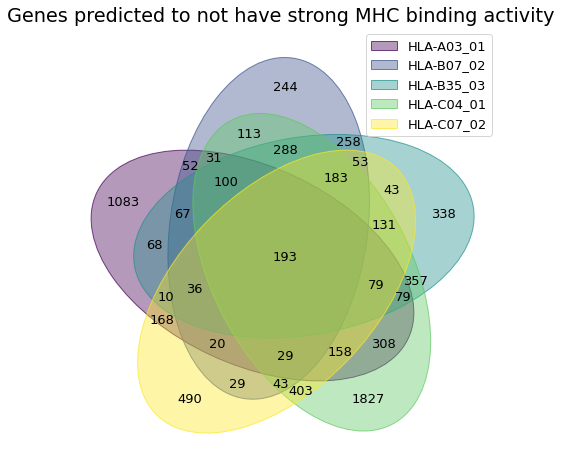

In [26]:
sets = {alleles[i]: set(binder_data[alleles[i]]['gene']['nonbinders']).
          union(set(binder_data[alleles[i]]['gene']['weakbinders']))
        for i in range(len(alleles))}
venn.venn(sets)
plt.savefig("fig2b_1.svg")
plt.title('Genes predicted to not have strong MHC binding activity')

Text(0.5, 1.0, 'Genes predicted to not have strong MHC binding activity')

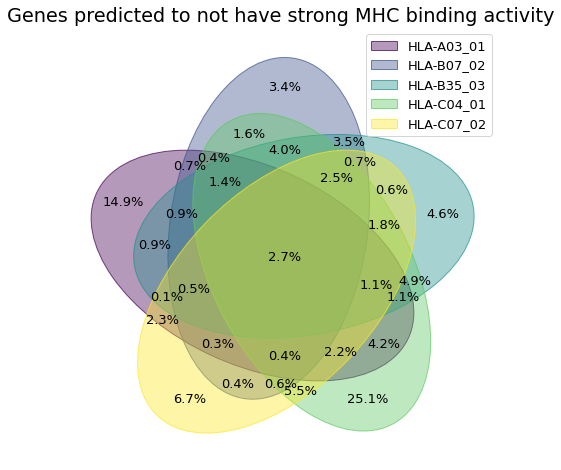

In [27]:
sets = {alleles[i]: set(binder_data[alleles[i]]['gene']['nonbinders']).
          union(set(binder_data[alleles[i]]['gene']['weakbinders']))
        for i in range(len(alleles))}
venn.venn(sets, fmt="{percentage:.1f}%")
plt.savefig("fig2b_2.svg")
#venn.venn(sets)
plt.title('Genes predicted to not have strong MHC binding activity')

In [10]:
for allele in alleles:
    print(len(binder_data[allele]['guide']['all']))

2301294
2265871
2301294
2301294
2301294


### Bar plots

In [10]:
## Bar plot for binder v/s non binder GENES
## No binding, No binding or weak binding, strong binding

plot_genes = {}
plot_genes['safes'] = []
plot_genes['weaks'] = []
plot_genes['highs'] = []

for allele in alleles:
    plot_genes['safes'].append(len(set(binder_data[allele]['gene']['nonbinders']))/
          len(set(binder_data[allele]['gene']['all'])))
    plot_genes['highs'].append(len(set(binder_data[allele]['gene']['highbinders']))/
          len(set(binder_data[allele]['gene']['all'])))
    plot_genes['weaks'].append(len(set(binder_data[allele]['gene']['weakbinders']))/
          len(set(binder_data[allele]['gene']['all'])))

In [11]:
## Bar plot for binder v/s non binder GUIDES
## No binding, No binding or weak binding, strong binding

plot_guides = {}
plot_guides['safes'] = []
plot_guides['weaks'] = []
plot_guides['highs'] = []

for allele in alleles:
    plot_guides['safes'].append(len(set(binder_data[allele]['guide']['nonbinders']))/
          len(set(binder_data[allele]['guide']['all'])))
    plot_guides['highs'].append(len(set(binder_data[allele]['guide']['highbinders']))/
          len(set(binder_data[allele]['guide']['all'])))
    plot_guides['weaks'].append(len(set(binder_data[allele]['guide']['weakbinders']))/
          len(set(binder_data[allele]['guide']['all'])))

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.
    From StackOverflow"""

    fig = plt.figure(figsize=(10,8))
    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))

    if grid:
        plt.grid()

    if show_values:
        for axis in axes[1:]:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

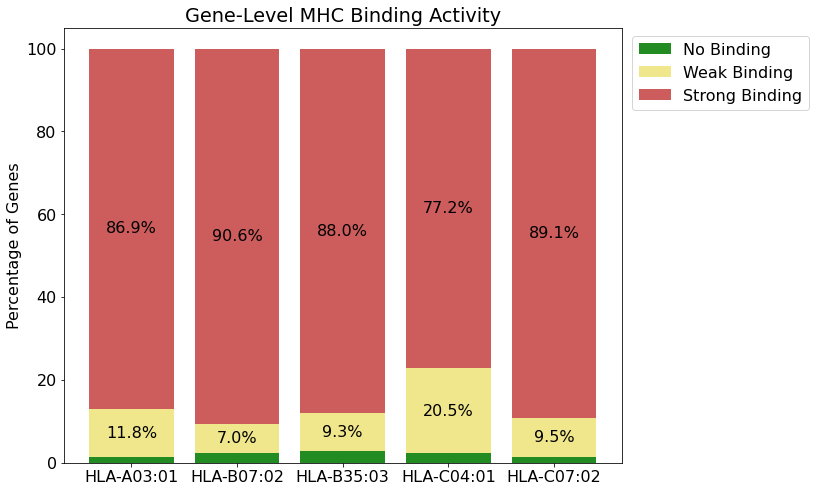

In [13]:
data = np.array([plot_genes['safes'],
              plot_genes['weaks'],
              plot_genes['highs']])
data = data*100

allele_labels = ['HLA-A03:01', 'HLA-B07:02', 'HLA-B35:03', 'HLA-C04:01', 'HLA-C07:02']

plot_stacked_bar(data, series_labels=['No Binding', 'Weak Binding', 'Strong Binding'], 
                 category_labels=allele_labels, 
                 show_values=True, value_format="{:2.1f}%", 
                 y_label='Percentage of Genes', 
                 colors=['forestgreen', 'khaki', 'indianred'], grid=False, reverse=False)
plt.title('Gene-Level MHC Binding Activity')

plt.savefig('fig1a.svg',dpi=300, bbox_inches = "tight")

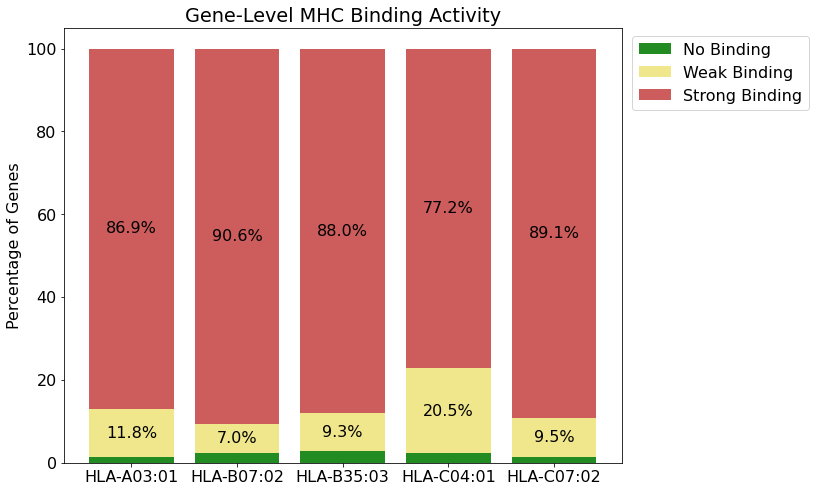

In [14]:
data = np.array([plot_genes['safes'],
              plot_genes['weaks'],
              plot_genes['highs']])
data = data*100

allele_labels = ['HLA-A03:01', 'HLA-B07:02', 'HLA-B35:03', 'HLA-C04:01', 'HLA-C07:02']

plot_stacked_bar(data, series_labels=['No Binding', 'Weak Binding', 'Strong Binding'], 
                 category_labels=allele_labels, 
                 show_values=True, value_format="{:2.1f}%", 
                 y_label='Percentage of Genes', 
                 colors=['forestgreen', 'khaki', 'indianred'], grid=False, reverse=False)
plt.title('Gene-Level MHC Binding Activity')
plt.savefig('fig1a_withtext.svg',dpi=300, bbox_inches = "tight")

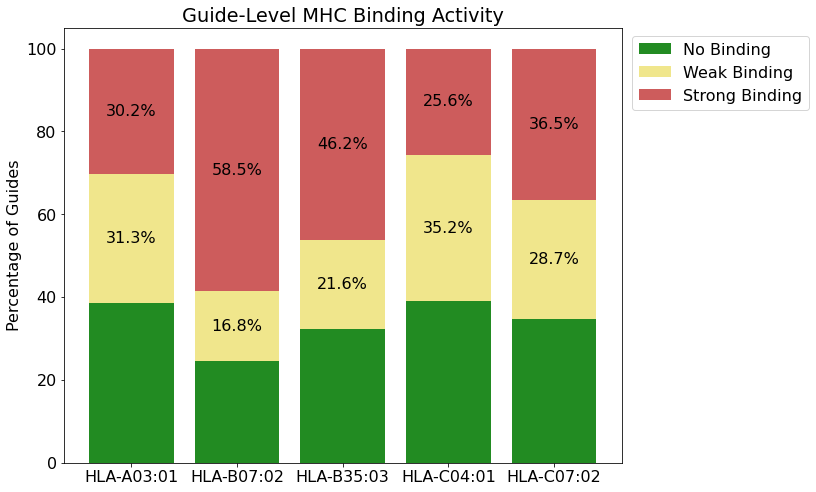

In [15]:
data = np.array([plot_guides['safes'],
              plot_guides['weaks'],
              plot_guides['highs']])
data = data*100

allele_labels = ['HLA-A03:01', 'HLA-B07:02', 'HLA-B35:03', 'HLA-C04:01', 'HLA-C07:02']

plot_stacked_bar(data, series_labels=['No Binding', 'Weak Binding', 'Strong Binding'], 
                 category_labels=allele_labels, 
                 show_values=True, value_format="{:2.1f}%", 
                 y_label='Percentage of Guides', 
                 colors=['forestgreen', 'khaki', 'indianred'], grid=False, reverse=False)
plt.title('Guide-Level MHC Binding Activity')

plt.savefig('fig1b.svg',dpi=300, bbox_inches = "tight")

In [320]:
def write_to_file(fname, allele, data):
    with open(fname+allele+'.txt', 'w') as f:
        for item in set(data):
            f.write("%s\n" % str(item))    

# Save output to file
for allele in alleles:
    write_to_file('nonbinders_geneID_', allele, list(set(binder_data[allele]['gene']['nonbinders'])))
    write_to_file('nothighbinders_geneID_', allele, list(set(binder_data[allele]['gene']['all']).difference(set(binder_data[allele]['gene']['highbinders']))))
    write_to_file('all_geneID_', allele, list(set(binder_data[allele]['gene']['all'])))